In [1]:
import torch
import matplotlib.pyplot as plt
import time

def grid(width, height):
  hrange = torch.arange(width).unsqueeze(0).repeat([height, 1]).div(width)
  vrange = torch.arange(height).unsqueeze(1).repeat([1, width]).div(height)
  output = torch.stack([hrange, vrange], 0)
  return output


def checker(width, height, freq):
  hrange = torch.arange(width).reshape([1, width]).mul(freq / width / 2.0).fmod(1.0).gt(0.5)
  vrange = torch.arange(height).reshape([height, 1]).mul(freq / height / 2.0).fmod(1.0).gt(0.5)
  output = hrange.logical_xor(vrange).float()
  return output

# Note the inputs are grid coordinates and the target is a checkerboard
inputs = grid(512, 512).unsqueeze(0).cuda()
targets = checker(512, 512, 8).unsqueeze(0).unsqueeze(1).cuda()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import time, gc

# Timing utilities
start_time = None

def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time.time()
    print("\n" + local_msg)
    print("Total execution time = {:.3f} sec".format(end_time - start_time))
    print("Max memory used by tensors = {} bytes".format(torch.cuda.max_memory_allocated()))

In [3]:
class Net(torch.jit.ScriptModule):
  def __init__(self):
    super().__init__()
    self.net = torch.nn.Sequential(
      torch.nn.Conv2d(2, 256, 1),
      torch.nn.BatchNorm2d(256),
      torch.nn.ReLU(),
      torch.nn.Conv2d(256, 256, 1),
      torch.nn.BatchNorm2d(256),
      torch.nn.ReLU(),
      torch.nn.Conv2d(256, 256, 1),
      torch.nn.BatchNorm2d(256),
      torch.nn.ReLU(),
      torch.nn.Conv2d(256, 1, 1))

  @torch.jit.script_method
  def forward(self, x):
    return self.net(x)

/opt/conda/lib/python3.8/site-packages/torch/cuda/memory.py:278: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


tensor(0.0962, device='cuda:0', grad_fn=<MseLossBackward0>)

Single precision
Total execution time = 24.427 sec
Max memory used by tensors = 2691764224 bytes


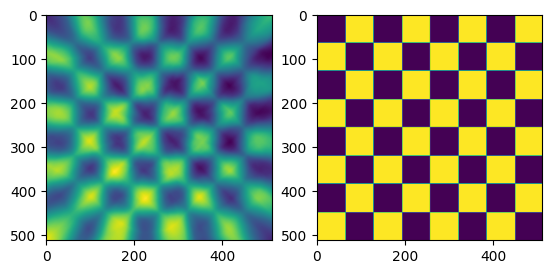

In [4]:
start_timer()
net = Net().cuda()
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), 0.001)

for i in range(500):
  opt.zero_grad()
  outputs = net(inputs)
  loss = loss_fn(outputs, targets)
  loss.backward()
  opt.step()
print(loss)

end_timer_and_print('Single precision')
plt.subplot(1,2,1); plt.imshow(outputs.squeeze().detach().cpu());
plt.subplot(1,2,2); plt.imshow(targets.squeeze().cpu()); plt.show()

/opt/conda/lib/python3.8/site-packages/torch/cuda/memory.py:278: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


tensor(0.0761, device='cuda:0', grad_fn=<MseLossBackward0>)

Mixed precsion
Total execution time = 14.564 sec
Max memory used by tensors = 1618810368 bytes


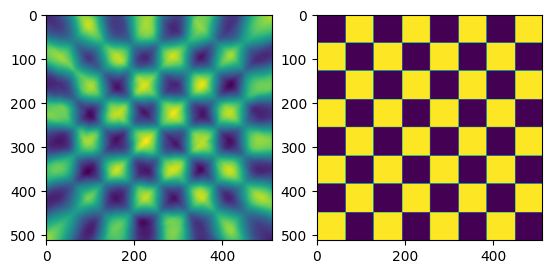

In [6]:
start_timer()
net = Net().cuda()
loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), 0.001)

scaler = torch.cuda.amp.GradScaler()

for i in range(500):
  opt.zero_grad()
  with torch.cuda.amp.autocast():
    outputs = net(inputs)
    loss = loss_fn(outputs, targets)
  scaler.scale(loss).backward()
  scaler.step(opt)
  scaler.update()
print(loss)

end_timer_and_print('Mixed precsion')
plt.subplot(1,2,1); plt.imshow(outputs.squeeze().detach().cpu().float());
plt.subplot(1,2,2); plt.imshow(targets.squeeze().cpu().float()); plt.show()